<a href="https://colab.research.google.com/github/jedcheng/feellgood_scripts/blob/main/cylinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install the library needed 

In [ ]:
!sudo apt-get update
!sudo apt-get install unzip make cmake git g++ libtbb-dev libyaml-cpp-dev

Download my pre-compiled binary

In [ ]:
!wget https://github.com/jedcheng/feellgood_scripts/raw/main/feellgood
!chmod -R 777 feellgood

I created a cylinder (10nm thick, 100nm radius, cell size 4nm) using the tools in the FEELLGOOD repo 



In [ ]:
!wget https://github.com/jedcheng/feellgood_scripts/raw/main/cylinder.msh

--2023-05-09 23:57:08--  https://github.com/jedcheng/feellgood_scripts/raw/main/cylinder.msh
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jedcheng/feellgood_scripts/main/cylinder.msh [following]
--2023-05-09 23:57:08--  https://raw.githubusercontent.com/jedcheng/feellgood_scripts/main/cylinder.msh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1538773 (1.5M) [text/plain]
Saving to: ‘cylinder.msh.1’

cylinder.msh.1      100%[===================>]   1.47M  --.-KB/s    in 0.01s   

2023-05-09 23:57:09 (152 MB/s) - ‘cylinder.msh.1’ saved [1538773/1538773]



In [171]:
import os 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq

%config InlineBackend.figure_format = 'svg'


In [ ]:
# the output file from feellgood is a bit weird 
# but they are just csv

def remove_first_n_lines_and_write_to_file(csv_file, n, output_file):
  """Removes the first n lines of a CSV file and writes the output to a new file.

  Args:
    csv_file: The path to the CSV file.
    n: The number of lines to remove.
    output_file: The path to the output file.
  """

  with open(csv_file, 'r') as f:
    data = f.readlines()

  with open(output_file, 'w') as out:
    out.write("t	<Mx>	<My>	<Mz>	E_ex	E_demag	E_zeeman	E_tot\n")
    for line in data[n:]:
      out.write(line)

Define the function to analyze the data

In [249]:
def main(title):
  remove_first_n_lines_and_write_to_file("output/cylinder.evol", 5, "output.csv")

  df = pd.read_csv("output.csv", sep="\t")

  my_0 = df["<My>"].to_numpy()
  t0 = df["t"].to_numpy()

  f = interp1d(t0, my_0, "linear")

  t = np.arange(0, t0[-1], (t0[1] - t0[0]))
  my = f(t)

  plt.plot(t, my)
  plt.xlabel('t')
  plt.ylabel('m_y')
  plt.show()

  xf = fftfreq(len(t), t[1]-t[0])
  yf = fft(my)

  peak = xf[np.argmax(np.abs(yf[1:]))+1]/1e9
  peak_amp = np.abs(yf[np.argmax(np.abs(yf[1:]))+1])
  plt.plot(xf, np.abs(yf))
  plt.xlim(0, 20e9)
  plt.ylim(0, peak_amp*1.1)
  plt.xlabel("freqeuency (10GHz)")
  plt.ylabel("amplitude (a.u.)")
  plt.title(title)
  plt.show()
  print(peak)
  return 

In [ ]:
!mkdir output

In [235]:
template = """
outputs:
  final_time: 50e-9      # simulation time
  directory: output
  evol_time_step: 5e-13

mesh:
  filename: cylinder.msh
  scaling_factor: 1e-9  # mesh unit is nanometers
  volume_regions:
    volume:             # high-damping permalloy
      Ae: 1.07e-11         # exchange constant
      Js: 1             # µ₀Ms
      alpha_LLG: 0.01   # Gilbert damping
  surface_regions:
    surface:

initial_magnetization: [0.98, 0.02, 0]  

"""

Run a sine pulse

In [ ]:
freq = 2.4
with open("settings.yml", "w") as f:
    f.write(template)
    f.write(f"Bext: [1*sin(2*3.14*{freq}e9*t), 1*sin(2*3.14*{freq}e9*t), 1*sin(2*3.14*{freq}e9*t)]")



Run a sinc pulse

In [236]:
with open("settings.yml", "w") as f:
    freq = 25
    amp = 0.2
    f.write(template)
    f.write(f"Bext: [{amp}*sinc(2*3.14*{freq}e9*t), {amp}*sinc(2*3.14*{freq}e9*t), {amp}*sinc(2*3.14*{freq}e9*t)]")


Use this to run FEELLGOOD if you don't have access to the colab terminal

In [ ]:
!./feellgood settings.yml

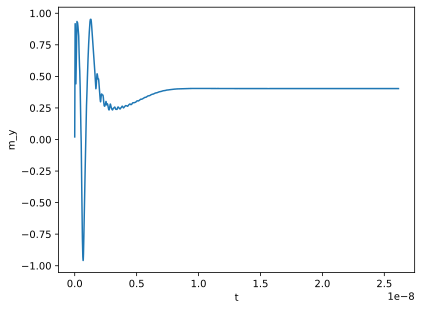

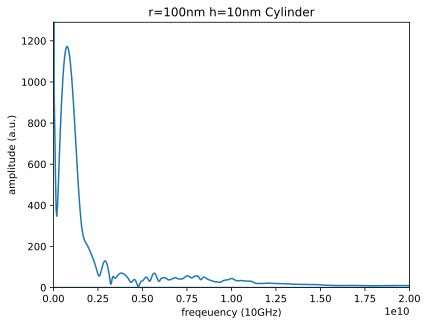

0.7650085107196819


In [250]:
main(title="r=100nm h=10nm Cylinder")